Steps:  
1. get simulator working
2. Try MHE with data
3. Simulate disturbances
4. Control with MHE for estimating the disturbance and MPC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO
import pandas as pd
from scipy.interpolate import interp1d
from IPython import display
from scipy.integrate import odeint

# Simulator

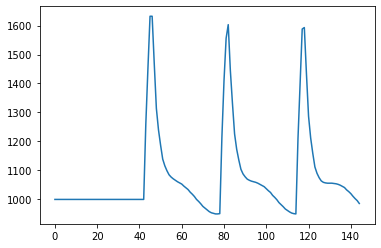

In [2]:
# Steady State for the Disturbance
d_ss = 1000.0 # mmol/L-min

# Final Time (hr)
tf = 24      # simulate for 24 hours
ns = tf*6+1  # sample time = 10 min

# Time Interval (min)
t = np.linspace(0,tf,ns)

d = np.ones(len(t)) * d_ss

# Add meal disturbances
meals = [1259,1451,1632,1632,1468,1314,1240,1187,1139,1116,\
          1099,1085,1077,1071,1066,1061,1057,1053,1046,1040,\
          1034,1025,1018,1010,1000,993,985,976,970,964,958,\
          954,952,950,950,951,1214,1410,1556,1603,1445,1331,\
          1226,1173,1136,1104,1088,1078,1070,1066,1063,1061,\
          1059,1056,1052,1048,1044,1037,1030,1024,1014,1007,\
          999,989,982,975,967,962,957,953,951,950,1210,1403,\
          1588,1593,1434,1287,1212,1159,1112,1090,1075,1064,\
          1059,1057,1056,1056,1056,1055,1054,1052,1049,1045,\
          1041,1033,1027,1020,1011,1003,996,986]
for i in range(len(meals)):
    d[i+43] = meals[i]

plt.plot(d)
plt.show()

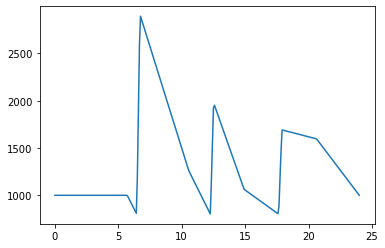

In [3]:
def get_situation(sim_interval=5):
    '''
    return time and  neccesary to simulate a day
    :param sim_interval: minutes per discretized interval'''
    # Meal data for disturbances
    # order:              [breakfast, snack1, lunch, snack2, dinner, snack3]
    meal_prob  = np.array([0.80     , 0.4   , 0.90 , 0.2   , 0.95  , 0.4   ])  # probability of having a meal
    meal_tm_lb = np.array([5        , 9     , 11   , 14    , 16    , 19    ])  # lower limit for time to have meal
    meal_tm_ub = np.array([9        , 11    , 14   , 16    , 19    , 23    ])  # upper limit to have meal
    meal_size  = np.array([2500     , 1250  , 2800 , 1250  , 2800  , 1250  ])  # normal meal size
    
    # probability stuff
    meal_score = np.random.rand(len(meal_prob))                                             # random number between 0 and 1 generated for each meal
    meal_occur = meal_prob > meal_score                                                     # Whether a meal will occur determined by random number
    meal_time = np.random.normal((meal_tm_lb + meal_tm_ub)/2, (meal_tm_ub - meal_tm_lb)/4)  # meal time is distributed normally with 95% between upper and lower bounds
    meal_size = meal_size * (np.random.rand(len(meal_prob))+0.5)                                       # meal size scaled by 0.5 to 1.5
    
    # Add base glucose rate
    sleep_glucose_tm = np.linspace(0, meal_time[0]-1, 3)
    sleep_glucose = np.ones(3) * 1000
    pre_meal_tm = meal_time.copy()[::2]-0.25
    pre_meal_glucose = np.ones(3) * 800

    interp_time = np.hstack((meal_time, sleep_glucose_tm, pre_meal_tm, 24)).ravel()
    interp_glucose = np.hstack((meal_size, sleep_glucose, pre_meal_glucose, 1000)).ravel()
    glucose_func = interp1d(interp_time, interp_glucose, kind='slinear')
    
    # create disturbance array (added glucose)
    sim_time = np.linspace(0, 24, int(24 * 60 / sim_interval+1))
    sim_disturbance = glucose_func(sim_time)
    return sim_time, sim_disturbance

sim_time, sim_disturbance = get_situation()
plt.plot(sim_time, sim_disturbance)
plt.show()

In [4]:
# TODO Establish Range of Variation, then use random step changes every few hours

def diabetic(gxiqqg, t, u, d):
    '''Bergman model for blood glucose'''
    g, x, i, q1, q2, gg = gxiqqg
    
    # Parameters
    
    gb = 291.0  # (mg/dL) Basal Blood Glucose
    p1 = 3.17e-2   # (1/min)
    p2 = 1.23e-2   # (1/min)
    si = 2.9e-2    # (1/min * (mL/micro-U)) Insulin Sensitivity
    ke = 9.0e-2    # (1/min) Insulin elimination from plasma
    kabs = 1.2e-2  # (1/min) t max,G inverse
    kemp = 1.8e-1  # (1/min) t max,I inverse
    f = 8.00e-1    # (L)
    vi = 12.0      # (L)     Insulin distribution volume
    vg = 12.0      # (L)     Glucose distibution volume
    
    dydt = np.empty(6)
    dydt[0] = -p1*(g-gb) - si*x*g + f*kabs/vg * gg + f/vg * d
    dydt[1] =  p2*(i-x) # remote insulin compartment dynamics
    dydt[2] = -ke*i + u # insulin dynamics
    dydt[3] = u - kemp * q1
    dydt[4] = -kemp*(q2-q1)
    dydt[5] = kemp*q2 - kabs*gg

    # convert from minutes to hours
    dydt = dydt*60
    return dydt

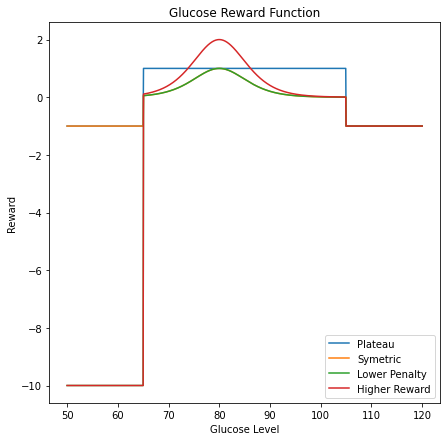

In [5]:
# Objective function variables
target = 80 # target
slope = 0.7
ub = 105     # upper bound
lb = 65    # lower bound
lm = 10     # lower penalty multiplier

glucose_ = np.linspace(50, 120, 1000)
a = []  # plateau
b = []  # Symmetric
c = []  # penalize low
d = []  # increase reward for 80 
for g in glucose_:
    if g < lb:
        aa = -1
        bb = -1
        cc = -1 * lm
        dd = -1 * lm
    elif g > ub:
        aa = -1
        bb = -1
        cc = -1
        dd = -1
    else:
        aa = 1
        bb = 1.0 - np.tanh(np.abs((g - target) / slope) * .1) **2
        cc = 1.0 - np.tanh(np.abs((g - target) / slope) * .1) **2
        dd = 2.0 - 2* np.tanh(np.abs((g - target) / slope) * .1) **2
    a.append(aa)
    b.append(bb)
    c.append(cc)
    d.append(dd)
    
# plot reward function
plt.figure(figsize=(7,7))
plt.title('Glucose Reward Function')
plt.plot(glucose_, a, label='Plateau')
plt.plot(glucose_, b, label='Symetric')
plt.plot(glucose_, c, label='Lower Penalty')
plt.plot(glucose_, d, label='Higher Reward')
plt.xlabel('Glucose Level')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [15]:
def sim_day(objective='d', graph=True, noise=True, avg_meas=True, disturbance=None):
    """
    
    """
    ##### Take input Data #####
    objective = objective.lower()
    if objective not in ['a', 'b', 'c', 'd']:
        print(f'Objective input "{objective}" not an acceptable input')
        return 1
    
    ##### Get time and disturbance #####
    if disturbance is None:
        time_, disturbance_ = get_situation()
    else:
        time_ = np.linspace(0, 24, len(disturbance))
        disturbance_ = disturbance
    tmerr_ = []
    
    ##### Storage Arrays #####
    G_ = np.ones_like(time_) * 76
    Gnoise_ = np.ones_like(time_) * 76
    Gmeas_ = np.ones_like(time_) * 76
    U_ = np.ones_like(time_) * 0
    GXISSG = np.empty((len(time_), 6))
    error_index = []
    
    ##### Initialize GEKKO Model #####
    m = GEKKO(remote=False)
    
    m.time = np.linspace(0, 60, 13)  # TODO: Check that this is the optimal time horizon
    
    # Params
    bg = m.Param(291.0, name='bg')  # (mg/dL) Basal Blood Glucose
    p1 = m.Param(3.17e-2, name='p1')   # (1/min)
    p2 = m.Param(1.23e-2, name='p2')   # (1/min)
    si = m.Param(2.9e-2)    # (1/min * (mL/micro-U))
    ke = m.Param(9.0e-2)    # (1/min) Insulin elimination from plasma
    kabs = m.Param(1.2e-2)  # (1/min) t max,G inverse
    kemp = m.Param(1.8e-1)  # (1/min) t max,I inverse
    f = m.Param(8.00e-1)    # (L)
    vi = m.Param(12.0)      # (L)     Insulin distribution volume
    vg = m.Param(12.0)      # (L)     Glucose distibution volume
    
    fin = np.zeros_like(m.time)
    fin[-1] = 1
    final = m.Param(fin)
    
    # FV (disturbance)
    D = m.FV(1000)
    
    # Variables
    # TODO: Initial Values
    G = m.CV(76.22)    # (mg/dL) Blood Glucose
    X = m.Var(33.33)      # (μu/ml) Remote Insulin
    I = m.Var(33.33)      # (μu/ml) Plasma Insulin
    U = m.MV(0, lb=0, ub=10)       # (mU/min) Insulin Delivery
    GG = m.Var(250.0)     # (mg/dL) Gut insulin

    S1 = m.Var(16.67)     # Intermediate 1
    S2 = m.Var(16.67)     # Intermediate 2

    obj = m.Var(0)
    
    # Equations
    m.Equations([
        G.dt() == -p1 * (G-bg) - si * X * G + f * kabs / vg * GG + f / vg * D,  # Dynamic Insulin Rate
        X.dt() == p2 * (I - X),                                                 # Remote Insulin dynamics
        I.dt() == -ke * I + U,                                                  # Plasma Insulin Concentration
        S1.dt() == U - kemp * S1,                                               # Dynamic Model
        S2.dt() == -kemp * (S2 - S1),                                           # Dynamic Model
        GG.dt() == kemp * S2 - kabs * GG,
    ])
    
    if objective == 'd':
        m.Equation(obj.dt() == m.if3(G-lb, -1 * lm, m.if3(ub-G, -1, 2.0 - 2*m.tanh(m.abs3((G-target)/slope)*0.1)**2)))
    elif objective == 'a':
        m.Equation(obj.dt() == m.if3(G-lb, -1, m.if3(ub-G, -1, 1.0)))
    elif objective == 'b':
        m.Equation(obj.dt() == m.if3(G-lb, -1, m.if3(ub-G, -1, m.if3(ub-G, -1, 1.0 - m.tanh(m.abs3((G-target)/slope)*0.1)**2))))
    else:
        m.Equation(obj.dt() == m.if3(G-lb, -1 * lm, m.if3(ub-G, -1, 1.0 - m.tanh(m.abs3((G-target)/slope)*0.1)**2)))

    # Options
    ## Tuning
    D.STATUS = 0
    D.FSTATUS = 1
    
    U.STATUS = 1
    U.FSTATUS = 0
    # U.DCOST = 0.3
    
    G.STATUS = 0
    G.FSTATUS = 1

    ## Global options
    m.options.IMODE   = 6
    m.options.SOLVER  = 3
    m.options.MAX_ITER = 10000

    m.Maximize(obj * final)

    ##### Loop Though the Day #####
    states = np.array([76.22, 33.33, 33.33,16.67,16.67,250.0])
    for i in range(len(time_)-1): # 1 day, measuring every 5 min
        # give new disturbance measurement
        D.MEAS = disturbance_[i]
        if avg_meas:
            if i>4 and Gnoise_[i] > lb and Gnoise_[i] < ub:  # take average of last 5 measurements if not a dangerous (low or high) measurement
                Gmeas_[i] = (Gnoise_[i] + Gnoise_[i-1] + Gnoise_[i-2] + Gnoise_[i-3] + Gnoise_[i-4])/5
                G.MEAS = Gmeas_[i]
            else:
                Gmeas_[i] = Gnoise_[i]
                G.MEAS = Gmeas_[i]
        elif noise:
            Gmeas_[i] = Gnoise_[i]
            G.MEAS = Gmeas_[i]
        else:
            GMEAS = G_[i]
            
        try:
            m.solve(disp=False)
            U_[i] = U.NEWVAL
        except:
            error_index.append(i)
            U_[i] = U_[i-1]
            
        
        # Simulate
        time_slice = [time_[i], time_[i+1]]
        if noise:
            y = odeint(diabetic, states, time_slice, args=(U_[i]*np.random.uniform(low=0.95, high=1.05), disturbance_[i]))
        else:
            y = odeint(diabetic, states, time_slice, args=(U_[i], disturbance_[i]))
        states = y[-1]
        
        GXISSG[i+1] = states
        G_[i+1] = states[0]
        Gnoise_[i+1] = G_[i+1] * np.random.uniform(low=0.92, high=1.08)
        
        ##### Graph #####
        if graph:
            plt.figure(figsize=(10,10))
            plt.subplot(3, 1, 1)
            plt.title('Glucose Disturbance')
            plt.plot(time_, disturbance_)
            plt.vlines(time_[i], min(disturbance_), max(disturbance_), color='black')
            plt.ylabel('Ingested Glucose (mmol/ L min)')
            plt.subplot(3, 1, 2)
            if tmerr_:
                plt.plot(time_[error_index], G_[error_index], 'ro', label='Error')
            plt.plot(time_[:i], G_[:i],'b-', label='Actual Blood Glucose')
            if noise:
                plt.plot(time_[:i], Gnoise_[:i],'c-', label='Noise Measurement')
            if avg_meas:
                plt.plot(time_[:i], Gmeas_[:i],'g-', label='Avg Meas')
            plt.hlines([ub, lb], 0, time_[i],color='black', linestyles='dashed', label='Ideal Limits')
            plt.plot([0, time_[i]], [target, target],'k-', label='Target')
            plt.legend()
            plt.ylabel('Blood Glucose (mg/dL)')
            plt.title('Blood Glucose')
            plt.subplot(3,1,3)
            if tmerr_:
                plt.plot(time_[error_index], U_[error_index], 'ro', label='Error')
            plt.title('Insulin Delivery')
            plt.plot(time_[:i], U_[:i])
            plt.ylabel('Insulin Delivered (mU/min)')
            plt.show()
            display.clear_output(wait=True)
        
    ##### Return results dictionary #####
    results = {'time':time_,
              'disturbance':disturbance_,
              'glucose':G_,
              'noise':Gnoise_,
              'average':Gmeas_,
              'insulin':U_,
              'errors':tmerr_,
              'objective':obj.value[0]}
    
    return results

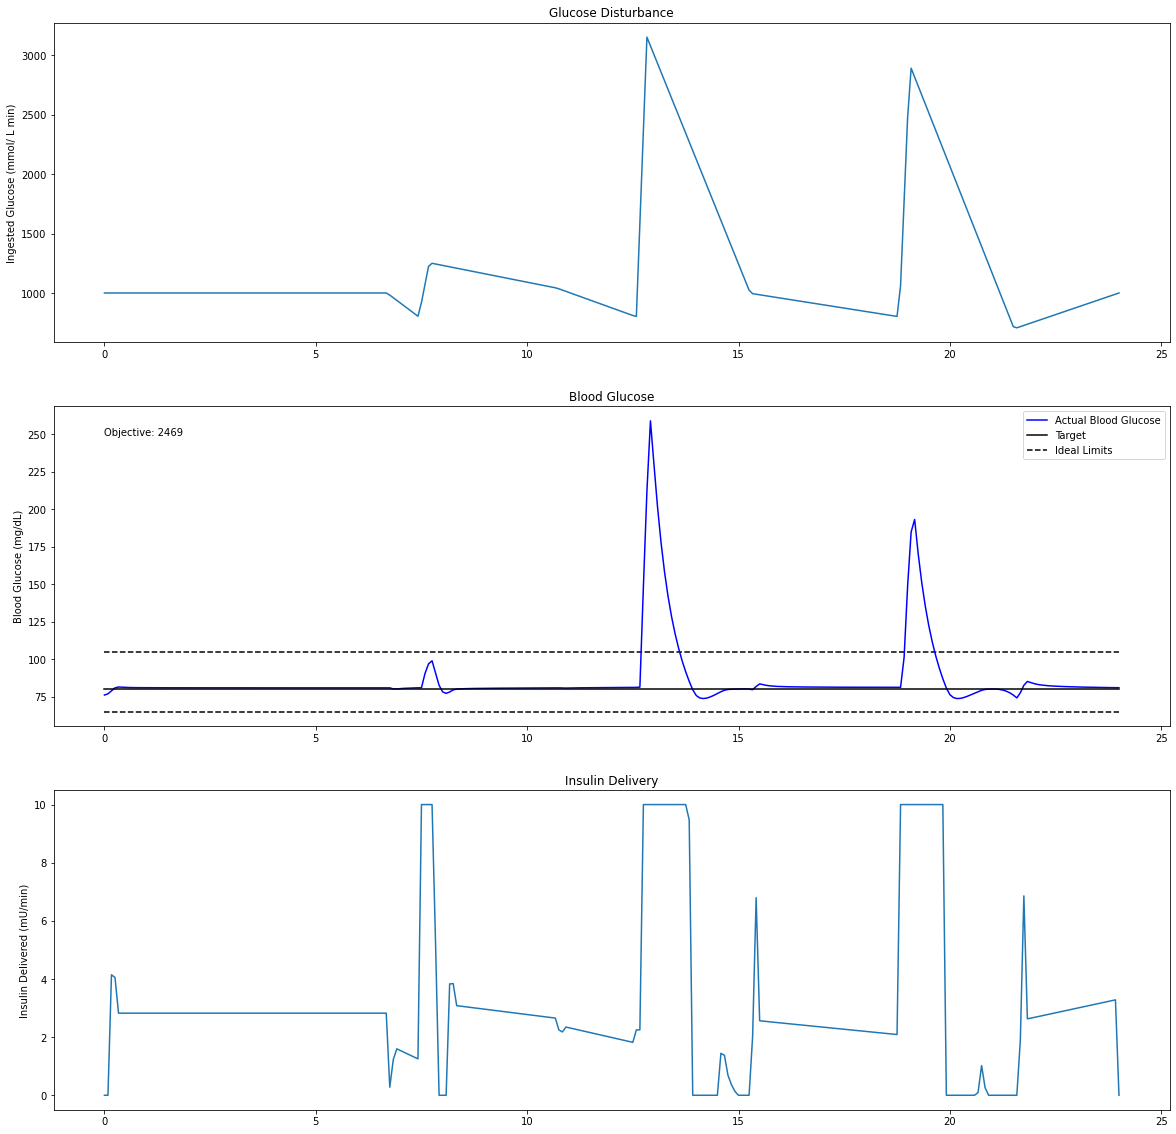

In [11]:
_, d = get_situation()

results = sim_day(noise=False, avg_meas=False, disturbance=d)

plt.figure(figsize=(20,20))
plt.subplot(3, 1, 1)
plt.title('Glucose Disturbance')
plt.plot(results['time'], results['disturbance'])
plt.ylabel('Ingested Glucose (mmol/ L min)')
plt.subplot(3, 1, 2)
plt.text(0, max(results['glucose'])-10, f"Objective: {results['objective']:.0f}")
plt.plot(results['time'], results['glucose'],'b-', label='Actual Blood Glucose')
plt.hlines([ub, lb], 0, 24,color='black', linestyles='dashed', label='Ideal Limits')
plt.plot([0, 24], [target, target],'k-', label='Target')
plt.legend()
plt.ylabel('Blood Glucose (mg/dL)')
plt.title('Blood Glucose')
plt.subplot(3,1,3)
plt.title('Insulin Delivery')
plt.plot(results['time'], results['insulin'])
plt.ylabel('Insulin Delivered (mU/min)')
plt.savefig('IdealControl.png')
plt.show()

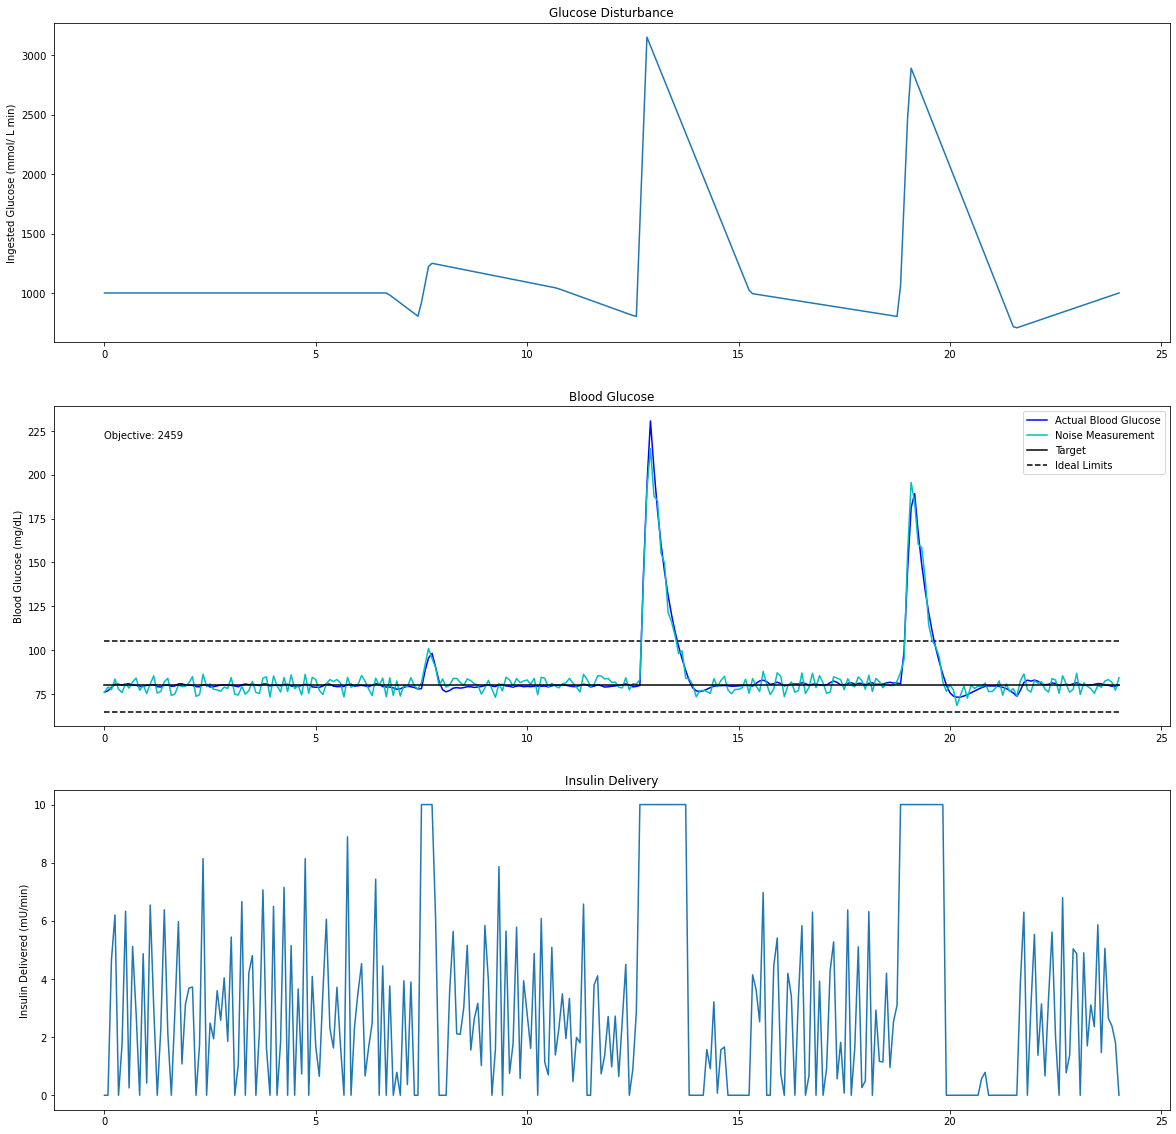

In [12]:
results = sim_day(avg_meas=False, disturbance=d)

plt.figure(figsize=(20,20))
plt.subplot(3, 1, 1)
plt.title('Glucose Disturbance')
plt.plot(results['time'], results['disturbance'])
plt.ylabel('Ingested Glucose (mmol/ L min)')
plt.subplot(3, 1, 2)
plt.text(0, max(results['glucose'])-10, f"Objective: {results['objective']:.0f}")
plt.plot(results['time'], results['glucose'],'b-', label='Actual Blood Glucose')
plt.plot(results['time'], results['noise'],'c-', label='Noise Measurement')
plt.hlines([ub, lb], 0, 24,color='black', linestyles='dashed', label='Ideal Limits')
plt.plot([0, 24], [target, target],'k-', label='Target')
plt.legend()
plt.ylabel('Blood Glucose (mg/dL)')
plt.title('Blood Glucose')
plt.subplot(3,1,3)
plt.title('Insulin Delivery')
plt.plot(results['time'], results['insulin'])
plt.ylabel('Insulin Delivered (mU/min)')
plt.savefig('NoiseControl.png')
plt.show()

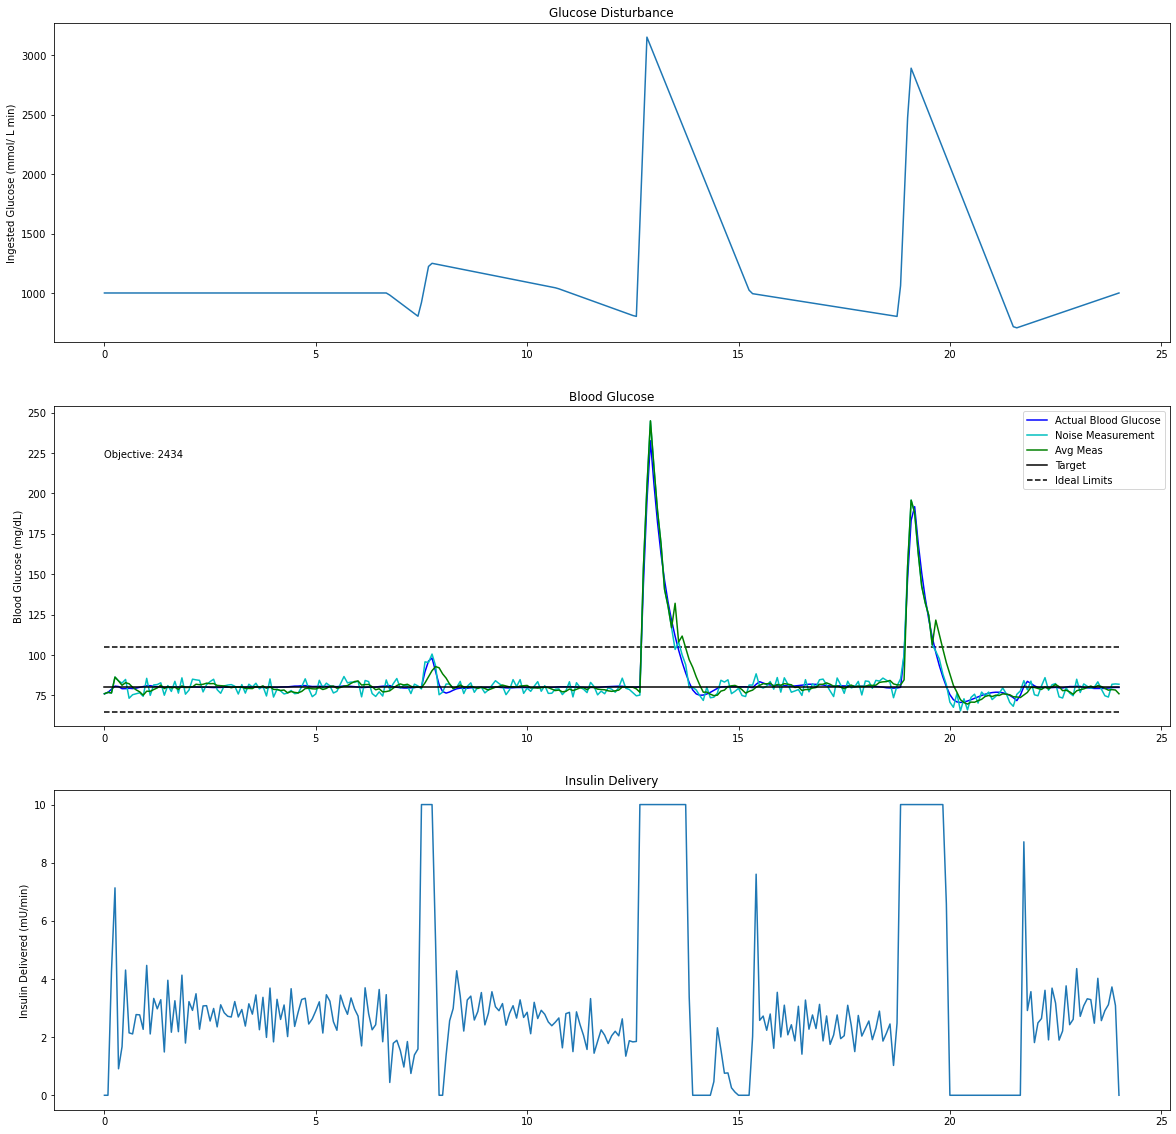

In [16]:
results = sim_day(disturbance=d)

plt.figure(figsize=(20,20))
plt.subplot(3, 1, 1)
plt.title('Glucose Disturbance')
plt.plot(results['time'], results['disturbance'])
plt.ylabel('Ingested Glucose (mmol/ L min)')
plt.subplot(3, 1, 2)
plt.text(0, max(results['glucose'])-10, f"Objective: {results['objective']:.0f}")
plt.plot(results['time'], results['glucose'],'b-', label='Actual Blood Glucose')
plt.plot(results['time'], results['noise'],'c-', label='Noise Measurement')
plt.plot(results['time'], results['average'],'g-', label='Avg Meas')
plt.hlines([ub, lb], 0, 24,color='black', linestyles='dashed', label='Ideal Limits')
plt.plot([0, 24], [target, target],'k-', label='Target')
plt.legend()
plt.ylabel('Blood Glucose (mg/dL)')
plt.title('Blood Glucose')
plt.subplot(3,1,3)
plt.title('Insulin Delivery')
plt.plot(results['time'], results['insulin'])
plt.ylabel('Insulin Delivered (mU/min)')
plt.savefig('AvgNoiseControl.png')
plt.show()

In [ ]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()
print(f'Parallelizing Code over {num_cores} cores')

